# Estimation of Muon Decay Time
## Avery Smidt and Alek Krupka

### Estimation of Muon Decay Time and Mixture Weight Using Synthetic Data

In [34]:
#NOTE: Future work section: hierarchical model with multiple data sets

# Pip imports
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoLocator

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [35]:
# Simulate Data
def gen_data(tau: float, w: float, num_samples: np.uint64):
    """
    Simulates synthetic scintillator data for a muon
    detection experiment. It generates a mixed distribution
    of an exponential and uniform distribution.

    Parameters:
    -----------
    tau         : float
        The decay time/lifetime of a muon.
    w           : float
        The mixture weight of the exponential distribution.
    num_samples : np.uint64
        Number of samples to be generated; size of the data.

    Returns:
    --------
    mixed_distr - a numpy uint64 array of decay times in
        nanoseconds.  Should be converted to a float type
        before calculations, but returned as a uint64 type
        to directly mimic the equivalent real experimental
        data. 
    """

    # Generate each distribution
    num_muons = int(w*num_samples)
    num_background = num_samples - num_muons
    obs_time_range = [1, 19999]
    muon_distr = np.random.exponential(scale=tau*10**3, size=(num_muons,)).astype(np.uint64)
    muon_distr[muon_distr==0] = 1
    background_distr = np.random.uniform(low=obs_time_range[0], high=obs_time_range[1] + 1, size=(num_background,)).astype(np.uint64)
    background_distr[background_distr==0] = 1

    mixed_distr = np.concatenate([muon_distr, background_distr])
    np.random.shuffle(mixed_distr)

    return mixed_distr

19.957 0.001


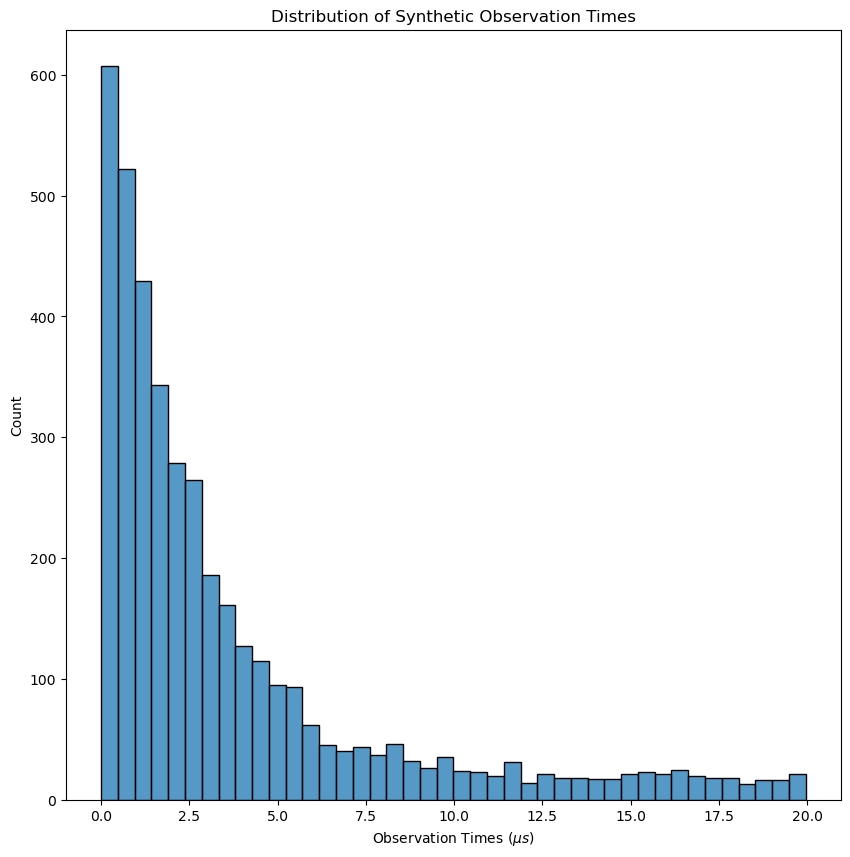

In [36]:
synth_data = gen_data(2.2, 0.8, 4004).astype(np.float64) * 10**(-3)
print(max(synth_data), min(synth_data))

# Bin detected decays into a histogram
width = 0.5
tau_distribution_synth, bin_edges = np.histogram(synth_data, bins=np.arange(min(synth_data), max(synth_data) + width, width))

#Calculate centers of the bins
bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2

# Plot histogram of experimental data
plt.figure(figsize=(10,10))
ax = sns.histplot(synth_data)
plt.title("Distribution of Synthetic Observation Times")
plt.xlabel("Observation Times ($\\mu s$)")

plt.savefig("Figures/synth_obs_times.png", format="png")

In [37]:
stan_code = """

data {
    int<lower=1> N; // Size of the data
    vector[N] y; // Observation times
    real<lower=0> y_max; // Maximum value data point in the y vector
}

parameters {
    real<lower=0> lambda; // Decay rate of a muon
    real<lower=0,upper=1> w; // Weight for the exponential (muon) distribution
}

model {
    // Priors
    lambda ~ inv_gamma(3, 1);
    w ~ beta(2, 2);

    // Likelihood
    for(n in 1:N){
        target += log_sum_exp(log(w) + 
                          exponential_lpdf(y[n] | lambda),
                          log1m(w) +
                          uniform_lpdf(y[n] | 0.001, y_max));
    }
}

"""

In [38]:
# Fit synthetic data using the Stan model to see if parameter recovery of the mixture weights is possible
data_dict = {
    "N": synth_data.shape[0],
    "y": synth_data,
    "y_max": np.max(synth_data)
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [39]:
# Fit the synthetic data
fit = model.sample(num_chains=4, num_samples=4000, num_warmup=1000)

Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   0% (3/20000)
Sampling:   0% (4/20000)
Sampling:   1% (103/20000)
Sampling:   1% (202/20000)
Sampling:   2% (301/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1900/20000)
Sampling:  10% (2000/20000)
Sampling:  10% (2100/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000

In [40]:
tau_estimated = 1/fit["lambda"][0]
w_estimated = fit['w'][0]

tau_posterior_mean = np.mean(tau_estimated)
tau_posterior_std = np.std(tau_estimated)

w_posterior_mean = np.mean(w_estimated)
w_posterior_std = np.std(w_estimated)

#Calculate the 95% confidence interval of tau
tau_posterior_lb = np.quantile(tau_estimated, 0.025)
tau_posterior_ub = np.quantile(tau_estimated, 0.975)

tau_posterior_lz = (tau_posterior_mean - tau_posterior_lb) / tau_posterior_std
tau_posterior_uz = (tau_posterior_ub - tau_posterior_mean) / tau_posterior_std

tau_posterior_uncertainty = (tau_posterior_uz + tau_posterior_lz) / 2

#Calculate the 95% confidence interval of w
w_posterior_lb = np.quantile(w_estimated, 0.025)
w_posterior_ub = np.quantile(w_estimated, 0.975)

w_posterior_lz = (w_posterior_mean - w_posterior_lb) / w_posterior_std
w_posterior_uz = (w_posterior_ub - w_posterior_mean) / w_posterior_std

w_posterior_uncertainty = (w_posterior_uz + w_posterior_lz) / 2

print(f"Mean Tau: {np.round(tau_posterior_mean, 3)} ± {tau_posterior_std * tau_posterior_uncertainty} 𝜇𝑠 with a confidence of 95%")
print(f"Tau 95% Confidence Interval: [{tau_posterior_mean + tau_posterior_std * tau_posterior_uz}, {tau_posterior_mean - tau_posterior_std * tau_posterior_lz}]")
print(f"Mean W: {np.round(w_posterior_mean, 4)} ± {w_posterior_std * w_posterior_uncertainty} 𝜇𝑠 with a confidence of 95%")
print(f"W 95% Confidence Interval: [{w_posterior_mean + w_posterior_std * w_posterior_uz}, {w_posterior_mean - w_posterior_std * w_posterior_lz}]")
az.summary(fit, var_names=['lambda', 'w',], filter_vars="like")

Mean Tau: 2.27 ± 0.11621155138179318 𝜇𝑠 with a confidence of 95%
Tau 95% Confidence Interval: [2.3873683294421197, 2.1549452266785334]
Mean W: 0.8103 ± 0.01999361750621098 𝜇𝑠 with a confidence of 95%
W 95% Confidence Interval: [0.8299658420049872, 0.7899786069925653]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.441,0.012,0.420,0.463,0.0,0.0,8190.0,9287.0,1.0
w,0.810,0.010,0.791,0.829,0.0,0.0,7868.0,9301.0,1.0


<Figure size 1000x1000 with 0 Axes>

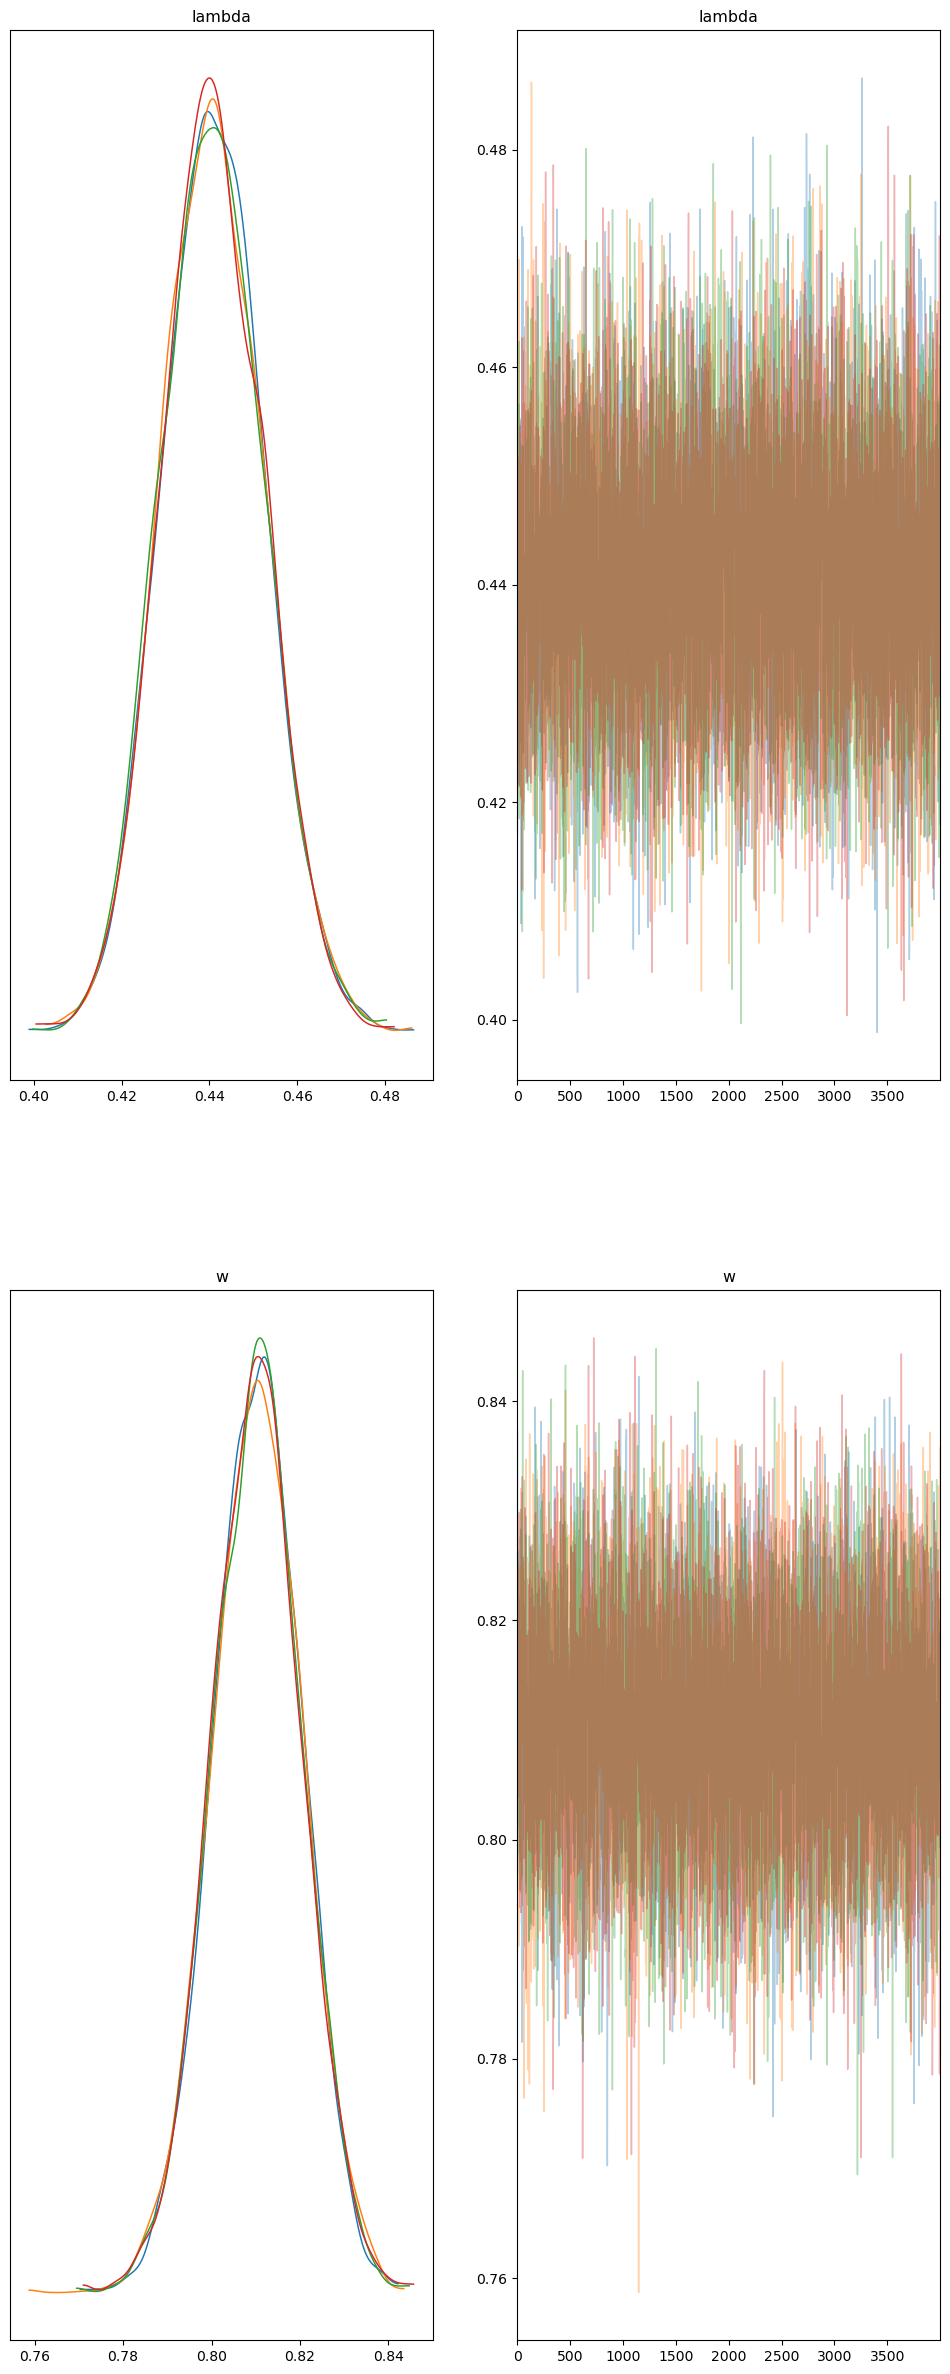

In [41]:
columns_to_plot_trace_of = ['lambda', 'w']

plt.figure(figsize=(10,10))
az.plot_trace(fit, var_names=columns_to_plot_trace_of, filter_vars='like', compact=False, figsize=(12, 30))

plt.savefig("Figures/synth_trace_plot.png", format="png")

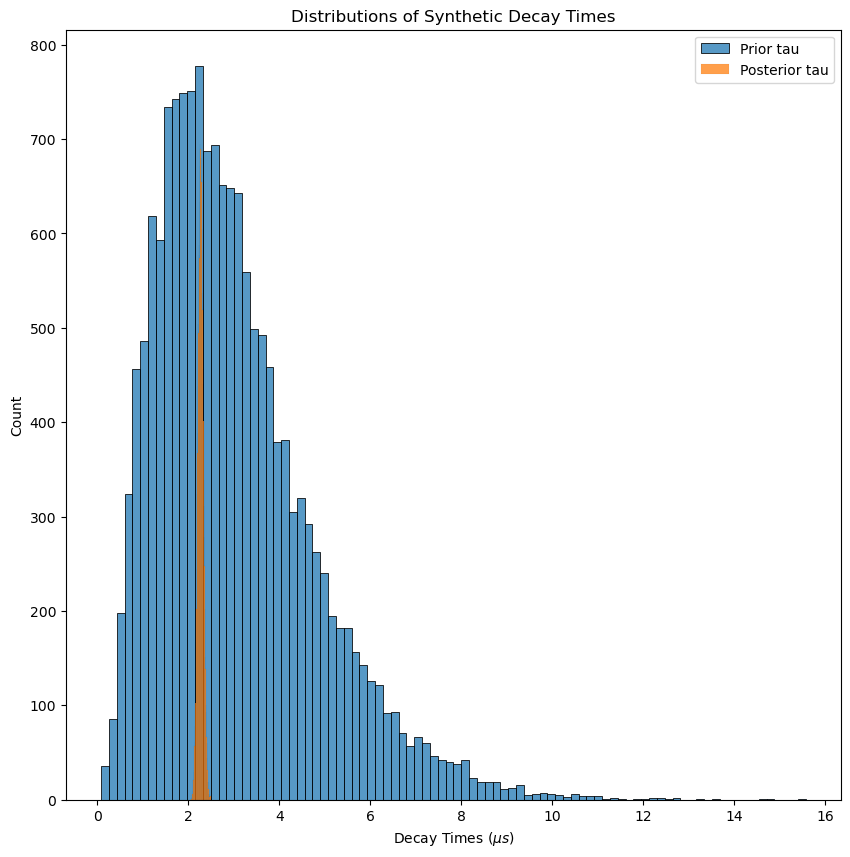

<Figure size 640x480 with 0 Axes>

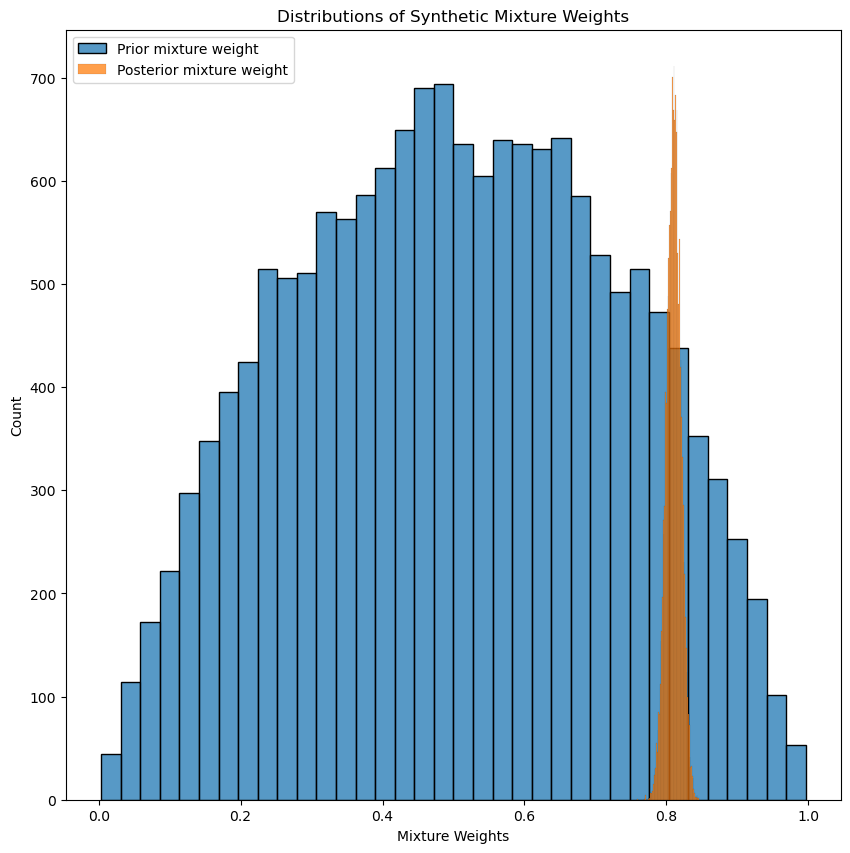

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot prior and posterior distributions of the decay time
tau_prior = np.random.gamma(3, scale=1, size=tau_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(tau_prior, label="Prior tau")
sns.histplot(tau_estimated, label="Posterior tau")
plt.title("Distributions of Synthetic Decay Times for Synthetic Data")
plt.xlabel("Decay Times ($\\mu s$)")
plt.legend()
plt.show()

plt.savefig("Figures/synth_prior_posterior_tau.png", format="png")

# Plot prior and posterior distributions of the weight
w_prior = np.random.beta(2, 2, size=w_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(w_prior, label="Prior mixture weight")
sns.histplot(w_estimated, label="Posterior mixture weight")
plt.title("Distributions of Synthetic Mixture Weights for Synthetic Data")
plt.xlabel("Mixture Weights")
plt.legend()
plt.show()

plt.savefig("Figures/synth_prior_posterior_w.png", format="png")

/tmp/ipykernel_21202/3611914754.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("Figures/synth_data_and_pred_posterior_kdes_tau.png", format="png")


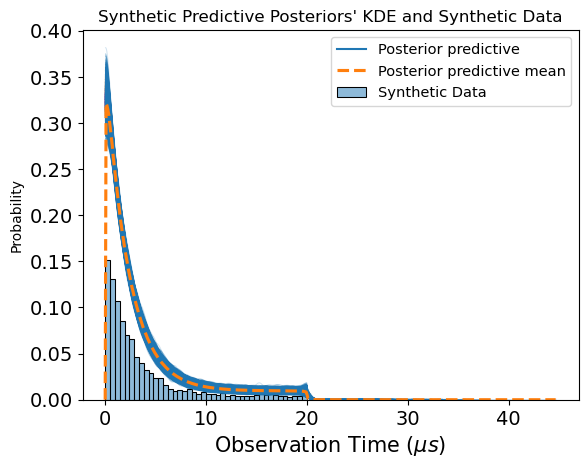

In [43]:
# Predictive Posterior
pred_tau = 1/fit["lambda"][0]
pred_w = fit["w"][0]

pred_posterior = []

for i in range(pred_tau.shape[0]):
    pred_posterior.append(gen_data(pred_tau[i], pred_w[i], 4004).astype(np.float64) * 10**(-3))

pred_posterior = np.array(pred_posterior).reshape(4, 4000, 4004)

plt.Figure(figsize=(10,10))
fig, ax = plt.subplots()

sns.histplot({'Synthetic Data': synth_data}, stat='probability', color=(0, 0, 0.9), label="Synthetic Data", ax=ax)

data_ppc = az.from_dict(posterior_predictive={"y_pred": pred_posterior},
                        observed_data={"synth_data": synth_data},
                        coords={"obs_idx": np.arange(4004)},
                        dims={"y_pred": ["chain", "draw", "obs_idx"], "synth_data": ["obs_idx"]})

az.plot_ppc(data_ppc, kind='kde', data_pairs={"synth_data" : "y_pred"}, observed=False, jitter=0, ax=ax)

plt.xlabel("Observation Time ($\\mu s$)")
plt.title("Synthetic Predictive Posteriors' KDE and Synthetic Data")

def probability_formatter(y, pos):
    return f'{y:.1f}'

ax.yaxis.set_major_locator(AutoLocator())

plt.savefig("Figures/synth_data_and_pred_posterior_kdes_tau.png", format="png")

### Estimation of Muon Decay Time and Mixture Weight Using Experimental Data

In [44]:
# Read in data
data = pd.read_csv("Data/sifted.csv", delimiter=';')
data = data.sample(frac=1).reset_index(drop=True)
print(data)
tau_experimental = np.array(data["ObsTime"].astype(np.float64) * 10**(-3)) # Separate the decay times and convert them from nanoseconds to microseconds

      ObsTime       Epoch
0        2160  1690519688
1        1260  1690482158
2        2720  1690509915
3        1200  1690451294
4         900  1690549570
...       ...         ...
4000      180  1690318601
4001     1900  1690482699
4002     3100  1690491649
4003     4840  1690363301
4004     2960  1690334079

[4005 rows x 2 columns]


19.84 0.04


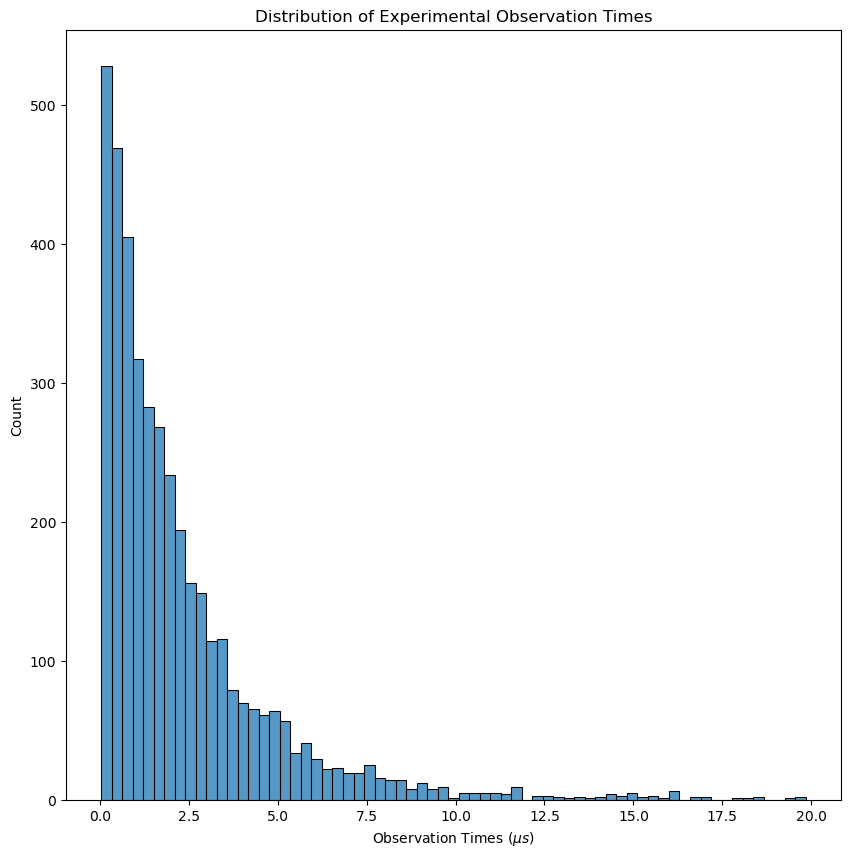

In [45]:
# Bin detected decays into a histogram
width = 0.5
tau_distribution, bin_edges = np.histogram(tau_experimental, bins=np.arange(min(tau_experimental), max(tau_experimental) + width, width))

print(max(tau_experimental), min(tau_experimental))

# Plot histogram of experimental data
plt.figure(figsize=(10,10))
ax = sns.histplot(tau_experimental)
plt.title("Distribution of Experimental Observation Times")
plt.xlabel("Observation Times ($\\mu s$)")

plt.savefig("Figures/exp_obs_times.png", format="png")

In [46]:
# Stan model
data_dict = {
    "N": tau_experimental.shape[0],
    "y": tau_experimental,
    "y_max": np.max(tau_experimental)
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [47]:
fit = model.sample(num_chains=4, num_samples=4000, num_warmup=1000)

Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   0% (3/20000)
Sampling:   0% (4/20000)
Sampling:   1% (103/20000)
Sampling:   1% (202/20000)
Sampling:   2% (301/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1900/20000)
Sampling:  10% (2000/20000)
Sampling:  10% (2100/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000

In [48]:
tau_estimated = 1/fit["lambda"][0]
w_estimated = fit['w'][0]

tau_posterior_mean = np.mean(tau_estimated)
tau_posterior_std = np.std(tau_estimated)

w_posterior_mean = np.mean(w_estimated)
w_posterior_std = np.std(w_estimated)

#Calculate the 95% confidence interval of tau
tau_posterior_lb = np.quantile(tau_estimated, 0.025)
tau_posterior_ub = np.quantile(tau_estimated, 0.975)

tau_posterior_lz = (tau_posterior_mean - tau_posterior_lb) / tau_posterior_std
tau_posterior_uz = (tau_posterior_ub - tau_posterior_mean) / tau_posterior_std

tau_posterior_uncertainty = (tau_posterior_uz + tau_posterior_lz) / 2

#Calculate the 95% confidence interval of w
w_posterior_lb = np.quantile(w_estimated, 0.025)
w_posterior_ub = np.quantile(w_estimated, 0.975)

w_posterior_lz = (w_posterior_mean - w_posterior_lb) / w_posterior_std
w_posterior_uz = (w_posterior_ub - w_posterior_mean) / w_posterior_std

w_posterior_uncertainty = (w_posterior_uz + w_posterior_lz) / 2

print(f"Mean Tau: {np.round(tau_posterior_mean, 3)} ± {tau_posterior_std * tau_posterior_uncertainty} 𝜇𝑠 with a confidence of 95%")
print(f"Tau 95% Confidence Interval: [{tau_posterior_mean + tau_posterior_std * tau_posterior_uz}, {tau_posterior_mean - tau_posterior_std * tau_posterior_lz}]")
print(f"Mean W: {np.round(w_posterior_mean, 4)} ± {w_posterior_std * w_posterior_uncertainty} 𝜇𝑠 with a confidence of 95%")
print(f"W 95% Confidence Interval: [{w_posterior_mean + w_posterior_std * w_posterior_uz}, {w_posterior_mean - w_posterior_std * w_posterior_lz}]")
az.summary(fit, var_names=['lambda', 'w',], filter_vars="like")

Mean Tau: 2.113 ± 0.07935682787394027 𝜇𝑠 with a confidence of 95%
Tau 95% Confidence Interval: [2.194691270147232, 2.0359776143993513]
Mean W: 0.9746 ± 0.00904837056671609 𝜇𝑠 with a confidence of 95%
W 95% Confidence Interval: [0.983069068154208, 0.9649723270207758]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.473,0.009,0.456,0.490,0.0,0.0,7778.0,8752.0,1.0
w,0.975,0.005,0.966,0.983,0.0,0.0,7005.0,7586.0,1.0


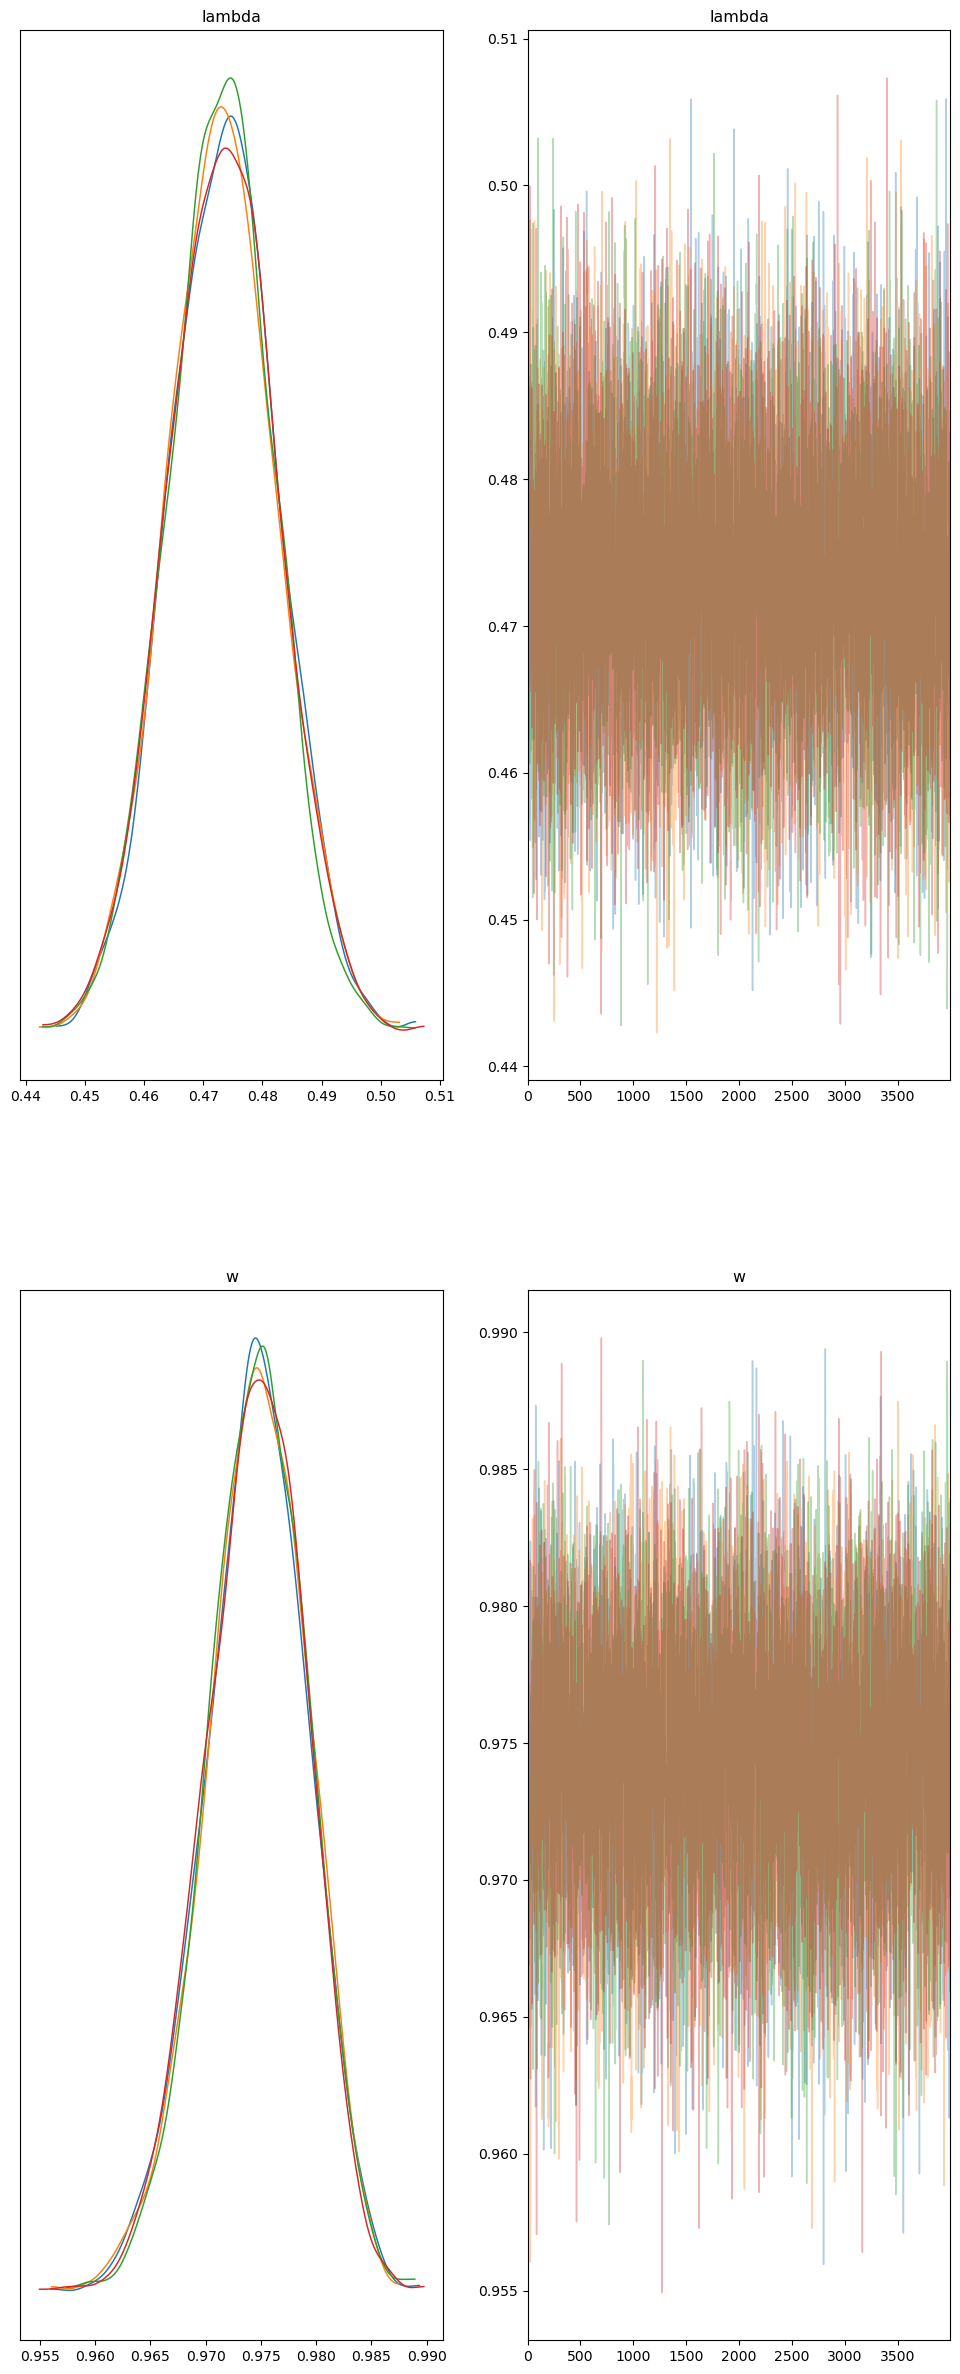

In [49]:
columns_to_plot_trace_of = ['lambda', 'w']

az.plot_trace(fit, var_names=columns_to_plot_trace_of, filter_vars='like', compact=False, figsize=(12, 30))

plt.savefig("Figures/exp_trace_plot.png", format="png")

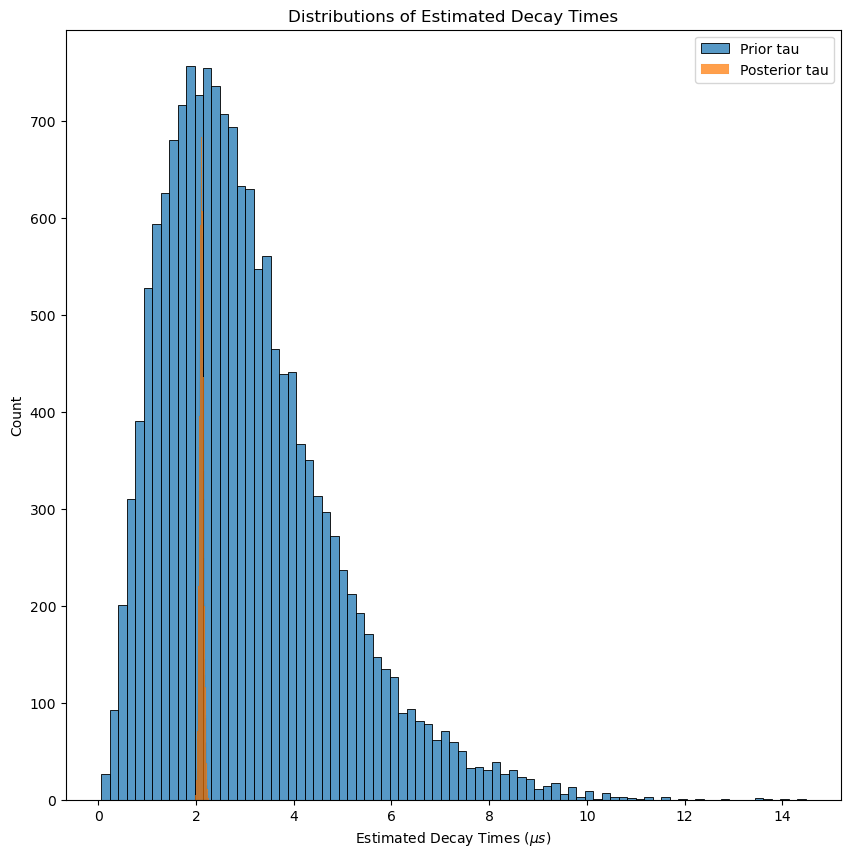

<Figure size 640x480 with 0 Axes>

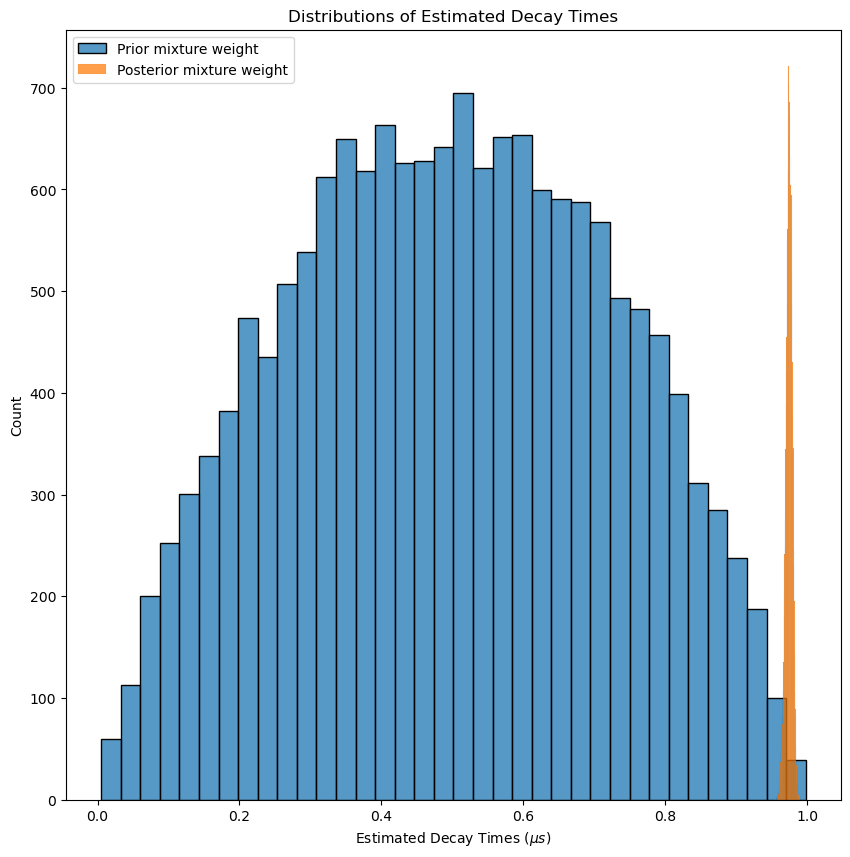

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot prior and posterior distributions of the decay time
tau_prior = np.random.gamma(3, scale=1, size=tau_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(tau_prior, label="Prior tau")
sns.histplot(tau_estimated, label="Posterior tau")
plt.title("Distributions of Estimated Decay Times for Experimental Data")
plt.xlabel("Estimated Decay Times ($\\mu s$)")
plt.legend()
plt.show()

plt.savefig("Figures/exp_prior_posterior_tau.png", format="png")

# Plot prior and posterior distributions of the weight
w_prior = np.random.beta(2, 2, size=w_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(w_prior, label="Prior mixture weight")
sns.histplot(w_estimated, label="Posterior mixture weight")
plt.title("Distributions of Estimated Decay Times for Experimental Data")
plt.xlabel("Estimated Decay Times ($\\mu s$)")
plt.legend()
plt.show()

plt.savefig("Figures/exp_prior_posterior_w.png", format="png")

/tmp/ipykernel_21202/2256923666.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("Figures/exp_data_and_pred_posterior_kdes_tau.png", format="png")
/home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


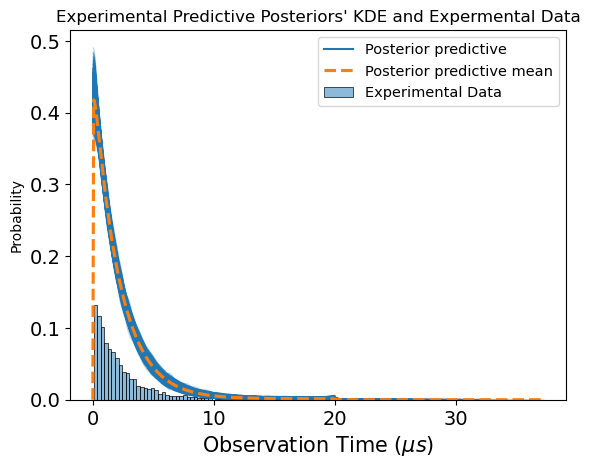

In [51]:
# Predictive Posterior
pred_tau = 1/fit["lambda"][0]
pred_w = fit["w"][0]

pred_posterior = []

for i in range(pred_tau.shape[0]):
    pred_posterior.append(gen_data(pred_tau[i], pred_w[i], tau_experimental.shape[0]).astype(np.float64) * 10**(-3))

pred_posterior = np.array(pred_posterior).reshape(4, 4000, tau_experimental.shape[0])

plt.Figure(figsize=(10,10))
fig, ax = plt.subplots()

sns.histplot({'Experimental Data': tau_experimental}, stat='probability', color=(0, 0, 0.9), label="Experimental Data", ax=ax)

data_ppc = az.from_dict(posterior_predictive={"y_pred": pred_posterior},
                        observed_data={"exp_data": tau_experimental},
                        coords={"obs_idx": np.arange(tau_experimental.shape[0])},
                        dims={"y_pred": ["chain", "draw", "obs_idx"], "exp_data": ["obs_idx"]})

az.plot_ppc(data_ppc, kind='kde', data_pairs={"exp_data" : "y_pred"}, observed=False, jitter=0, ax=ax)

plt.xlabel("Observation Time ($\\mu s$)")
plt.title("Experimental Predictive Posteriors' KDE and Expermental Data")

def probability_formatter(y, pos):
    return f'{y:.1f}'

ax.yaxis.set_major_locator(AutoLocator())

plt.savefig("Figures/exp_data_and_pred_posterior_kdes_tau.png", format="png")